In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

D0810 15:55:19.287256602      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0810 15:55:19.287316327      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0810 15:55:19.287320246      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0810 15:55:19.287323126      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0810 15:55:19.287325907      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0810 15:55:19.287328923      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0810 15:55:19.287331758      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0810 15:55:19.

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8
2.12.0


# Introduction

The task: the task we are asked to complete is to create a generative adversarial model (GAN) that will learn from the monet paintings and be able to convert a normal photo into their style. 

The data: the data is separated into two main categories. Monet paintings and photos to which we will convert to a monet style. Each data set comes in a jpg and tfrec format. There are 300 paintings and 7028 photos. All the images are 256x256x3.

Note that I will primarily focus on the tfrec files as they are more readily used in the GAN creation

In [3]:
# for loading data: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
GCS_PATH = KaggleDatasets().get_gcs_path()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))


Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    img = tf.image.decode_jpeg(image, channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    return img

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_image(example['image'])
    return img

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return data

In [7]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# EDA

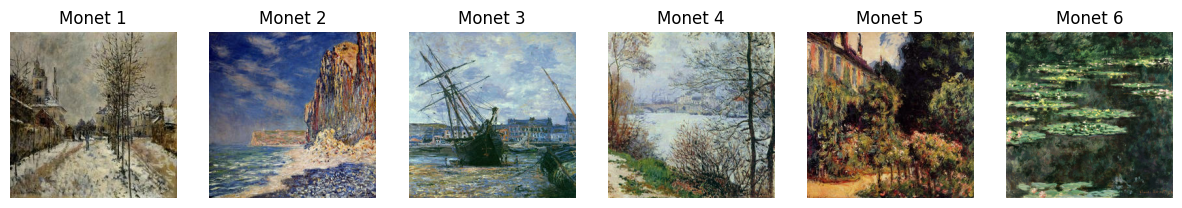

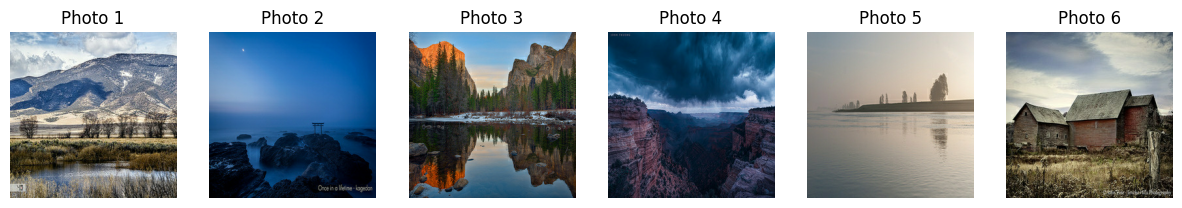

In [8]:
def display_images(dataset, title, n_images):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(dataset.take(n_images)):
        plt.subplot(1, n_images, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(image[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_images(monet_ds, 'Monet', 6)
display_images(photo_ds, 'Photo', 6)

# Model Architecture

As this was my first attempt creating a CycleGAN, the outline of my architecture was very simlar to the the archiectures of my first two refernces (at the end of the notebook). The CycleGAN utilizes two generators, one to go from photo to monet painting and one to go from painting to original photo as well as two discrimators, one to tell the difference between a real monet and one generated by the model and one to tell the difference between a real photo and one generated by the model.

To build the generators we need a downsample and upsample function that serve as an encoder and decoder respectively. This allows the model to learn the more minute features of the images.

In [9]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.01)

    res = tf.keras.Sequential()
    res.add(
      layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        res.add(tfa.layers.InstanceNormalization())

    res.add(tf.keras.layers.LeakyReLU())

    return res
  
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.01)

    res = tf.keras.Sequential()
    res.add(
    layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    res.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        res.add(layers.Dropout(0.5))

    res.add(layers.ReLU())

    return res
  
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), 
        downsample(128, 4),  
        downsample(256, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4), 
        downsample(512, 4),  
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.01)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

For build our discriminators we will leverage or downsample (encoder) function as well as several convolution layers. Remember, the purpose of our discriminator is to tell well an image is fake or not.

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.01)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    d1 = downsample(64, 4, False)(x) 
    d2 = downsample(128, 4)(d1)  
    d3 = downsample(256, 4)(d2) 

    zero_pad1 = layers.ZeroPadding2D()(d3) 
    conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)  

    norm1 = tfa.layers.InstanceNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  

    last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def generator_loss_fn(disc_generated_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)
    
    gan_loss = tf.nn.compute_average_loss(gan_loss, global_batch_size=BATCH_SIZE)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    tot_gen_loss = gan_loss + LAMBDA*l1_loss

    return tot_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)

    gen_loss = loss_obj(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + gen_loss

    return total_disc_loss

LAMBDA = 10

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

    
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss



Creating our optimizers which use Adam to update the weeights of our model.

In [ ]:
with strategy.scope():
    generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

CycleGAN class - This class takes all of the components of or model to this point, compiles them, and then trains it through a training loop.

Compile - Creation of our model so that it can be trained

Train step - Calculates the various loss values, gradients, and then applies the Adam optimizer. Looping over this will train the model.

In [12]:
class CycleGAN(tf.keras.Model):
    def __init__(
        self,
        monet_generator, 
        photo_generator, 
        monet_discriminator, 
        photo_discriminator, 
        lambda_cycle=10,
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        monet_r, photo_r = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            monet_f = self.m_gen(photo_r, training=True)
            photo_c = self.p_gen(monet_f, training=True)

            photo_f = self.p_gen(monet_r, training=True)
            monet_c = self.m_gen(photo_f, training=True)

            monet_s = self.m_gen(monet_r, training=True)
            photo_s = self.p_gen(photo_r, training=True)

            disc_monet_r = self.m_disc(monet_r, training=True)
            disc_photo_r = self.p_disc(photo_r, training=True)

            disc_monet_f = self.m_disc(monet_f, training=True)
            disc_photo_f = self.p_disc(photo_f, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_monet_f, monet_f, monet_r)
            photo_gen_loss = self.gen_loss_fn(disc_photo_f, photo_f, photo_r)

            total_cycle_loss = self.cycle_loss_fn(monet_r, monet_c) + self.cycle_loss_fn(photo_r, photo_c)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(monet_r, monet_s)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(photo_r, photo_s)

            monet_disc_loss = self.disc_loss_fn(disc_monet_r, disc_monet_f)
            photo_disc_loss = self.disc_loss_fn(disc_photo_r, disc_photo_f)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now we will define the loss functions, compile the model, and then train the model.

Generator Loss - This function is a combination encouraging the generator to create images that passes the discriminator as well as the difference between the generated and target image which is to say encourages the egenerator to create images that are close to the target image.

Discriminator Loss - This function is to calculate how good our discrimator is at accurately classifying real images.

Cycle Loss - This is our "feedback loop" or cycle loss that helps stabilize the learning process of the model.

Idenity Loss - How much our generated image has changed from the original.

In [13]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

LAMBDA = 10

with strategy.scope():
    model = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator, LAMBDA)

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

with strategy.scope():
    def generator_loss_fn(disc_generated_output, gen_output, target):
        gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        total_gen_loss = gan_loss + LAMBDA * l1_loss
        return total_gen_loss

with strategy.scope():
    def discriminator_loss_fn(disc_real_output, disc_generated_output):
        real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = loss_obj(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss

LAMBDA = 10

with strategy.scope():
    def cycle_loss_fn(real_image, cycled_image):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

with strategy.scope():
    def identity_loss_fn(real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

with strategy.scope():
    model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        p_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        m_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        p_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss_fn,
        disc_loss_fn = discriminator_loss_fn,
        cycle_loss_fn = cycle_loss_fn,
        identity_loss_fn = identity_loss_fn
    )

Below I train the model over 35 epochs.

In [14]:
model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=35
)

Epoch 1/35


2023-08-10 15:56:49.904976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-10 15:56:51.402850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 162s 132ms/step - monet_gen_loss: 10.6298 - photo_gen_loss: 11.2457 - monet_disc_loss: 1.4079 - photo_disc_loss: 1.4101
Epoch 2/35
300/300 [==============================] - 39s 130ms/step - monet_gen_loss: 9.0888 - photo_gen_loss: 9.6179 - monet_disc_loss: 1.3264 - photo_disc_loss: 1.3635
Epoch 3/35
300/300 [==============================] - 39s 131ms/step - monet_gen_loss: 8.8060 - photo_gen_loss: 9.3537 - monet_disc_loss: 1.3207 - photo_disc_loss: 1.3517
Epoch 4/35
300/300 [==============================] - 39s 129ms/step - monet_gen_loss: 8.6998 - photo_gen_loss: 9.2640 - monet_disc_loss: 1.3078 - photo_disc_loss: 1.3413
Epoch 5/35
300/300 [==============================] - 39s 131ms/step - monet_gen_loss: 8.6254 - photo_gen_loss: 9.2048 - monet_disc_loss: 1.3104 - photo_disc_loss: 1.3260
Epoch 6/35
300/300 [==============================] - 39s 131ms/step - monet_gen_loss: 8.5479 - photo_gen_loss: 9.1360 - monet_disc_loss: 1.3100 - photo_

# Results

Below are several examples of the output of the model compared to the orinal photo. It appears that the model does a fairly well job at converting the photos, largely thanks to the tutorials I was able to follow.

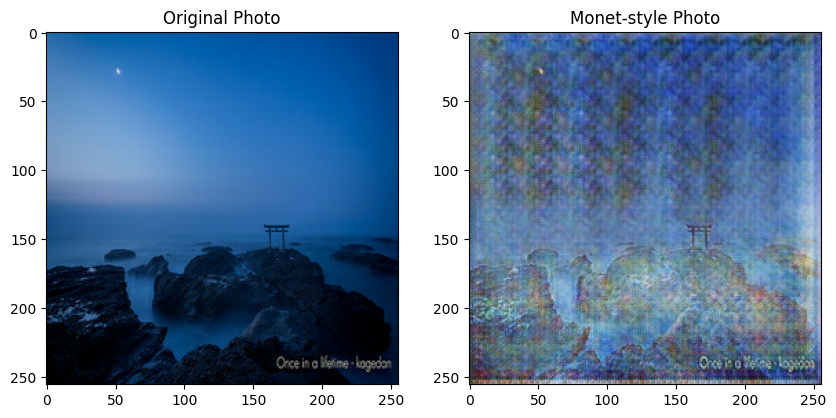

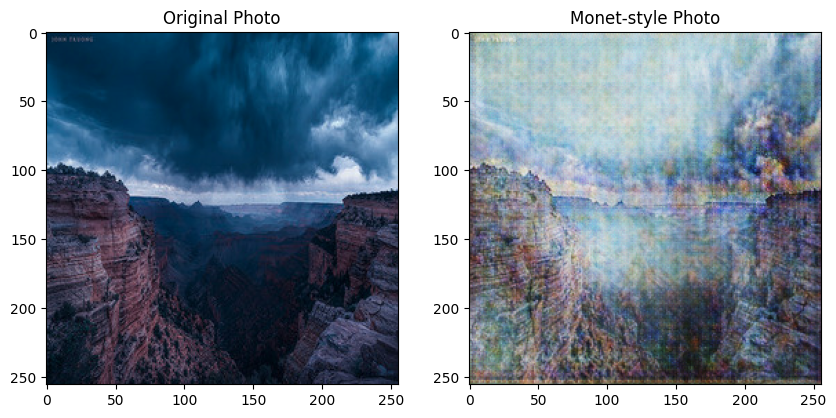

In [15]:
# Function for prediction and visualization
def visualize(input_image, model):
    prediction = model(input_image, training=False)[0].numpy() 
    prediction = (prediction * 127.5 + 127.5).astype(int)  

    plt.figure(figsize=(10,10))

    plt.subplot(1, 2, 1)
    plt.title('Original Photo')
    plt.imshow(input_image[0] * 0.5 + 0.5) 

    plt.subplot(1, 2, 2)
    plt.title('Monet-style Photo')
    plt.imshow(prediction)

    plt.show()

for img in photo_ds.take(5): 
    visualize(img, monet_generator)

Creating the submission

In [16]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Conclusion

Ultimately I am very satisfied with the result of this model although it proved very difficult to get working properly. The monet style photos seem to be farily realistic. In the future I would like to continue to iterate over this model and see if I can create a solution that is good enough to win the competition. This could include adjusting the archictecture, doing more hyperparamter tuning, and more. It would also be interesting to try a different type of GAN in the future and see how effective it would be.

References:
1. https://www.kaggle.com/code/conradkleykamp/using-gans-to-create-monet-style-art-cyclegan
2. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
3. https://towardsdatascience.com/hands-on-generative-adversarial-networks-gan-for-signal-processing-with-python-ff5b8d78bd28